In [1]:
import numpy as np
import time
import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

# Goal
Just a basic plug LSTM model in Keras to anal

In [3]:
cwd = os.getcwd()
series = pd.read_csv(os.path.join(cwd, "data", "ppl.us.txt"))
series.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1985-04-08,1.4892,1.4892,1.4599,1.4749,2972502,0
1,1985-04-09,1.4749,1.5039,1.4749,1.4892,1463242,0
2,1985-04-10,1.4892,1.5476,1.4892,1.5330,1253381,0
3,1985-04-11,1.5330,1.5476,1.5330,1.5330,677237,0
4,1985-04-12,1.5330,1.5476,1.5039,1.5039,809560,0


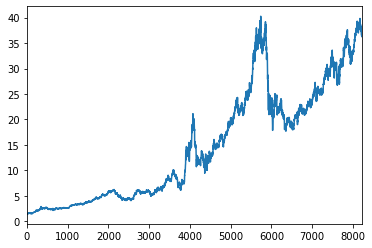

In [4]:
series['Close'].plot()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

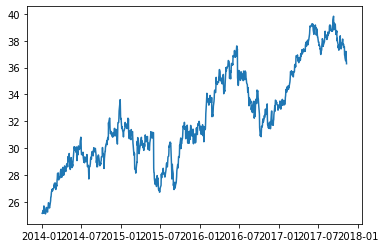

In [5]:
series['Date'] = pd.to_datetime(series['Date'])
mask = series['Date'] > '2014-01-01'
series = series[mask]
plt.plot(series['Date'], series['Close'])
plt.show

In [6]:
series = series.copy()
series['prev_Close'] = series['Close'].shift(1)
series = series.dropna()
series['diff'] = (series['Close'] - series['prev_Close'])
series.head(10)

,Date,Open,High,Low,Close,Volume,OpenInt,prev_Close,diff
7244,2014-01-03,25.452,25.487,24.926,25.115,4964871,0,25.140,-0.025
7245,2014-01-06,25.265,25.334,25.130,25.225,5196682,0,25.115,0.110
7246,2014-01-07,25.249,25.386,25.140,25.367,4999712,0,25.225,0.142
7247,2014-01-08,25.274,25.309,25.029,25.140,5265240,0,25.367,-0.227
7248,2014-01-09,25.181,25.239,25.078,25.181,6152858,0,25.140,0.041
7249,2014-01-10,25.350,25.723,25.342,25.683,5872148,0,25.181,0.502
7250,2014-01-13,25.563,25.697,25.418,25.553,4709937,0,25.683,-0.130
7251,2014-01-14,25.553,25.647,25.435,25.469,3988479,0,25.553,-0.084
7252,2014-01-15,25.444,25.495,25.164,25.172,7381630,0,25.469,-0.297
7253,2014-01-16,25.216,25.359,25.155,25.317,4579942,0,25.172,0.145


In [7]:
def seriesSequenceCreation(df, sequence_length=12):
    for i in range(1,sequence_length + 1):
        field_name = 'lag_' + str(i)
        df[field_name] = df['diff'].shift(i)
    return df.dropna().reset_index(drop=True)

In [8]:
series_supervised = series.drop(['Date', 'Open', 'High', 'Low', 'Volume', 'OpenInt'], axis=1)
series_supervised = seriesSequenceCreation(series_supervised)
series_supervised = series_supervised.drop(['prev_Close', 'Close'], axis=1)
series_supervised.head()

,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,0.238,0.237,-0.229,0.145,-0.297,-0.084,-0.130,0.502,0.041,-0.227,0.142,0.110,-0.025
1,0.008,0.238,0.237,-0.229,0.145,-0.297,-0.084,-0.130,0.502,0.041,-0.227,0.142,0.110
2,-0.246,0.008,0.238,0.237,-0.229,0.145,-0.297,-0.084,-0.130,0.502,0.041,-0.227,0.142
3,-0.100,-0.246,0.008,0.238,0.237,-0.229,0.145,-0.297,-0.084,-0.130,0.502,0.041,-0.227
4,0.262,-0.100,-0.246,0.008,0.238,0.237,-0.229,0.145,-0.297,-0.084,-0.130,0.502,0.041


In [9]:
train_row = int(round(0.9 * series_supervised.shape[0]))
train, test = series_supervised[:train_row].values, series_supervised[train_row:].values

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

train = train.reshape(train.shape[0], train.shape[1])
train = scaler.transform(train)
test = test.reshape(test.shape[0], test.shape[1])
test = scaler.transform(test)

X_train, y_train = train[:, 1:], train[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

X_test, y_test = test[:, 1:], test[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [10]:
print(X_train.shape)
print(X_test.shape)
print(X_train[:5])

(865, 1, 12)
(96, 1, 12)
[[[0.36690307 0.1465721  0.32340426 0.1144208  0.21513002 0.19338061
   0.49219858 0.27423168 0.14751773 0.32198582 0.30685579 0.243026  ]]

 [[0.36737589 0.36690307 0.1465721  0.32340426 0.1144208  0.21513002
   0.19338061 0.49219858 0.27423168 0.14751773 0.32198582 0.30685579]]

 [[0.25862884 0.36737589 0.36690307 0.1465721  0.32340426 0.1144208
   0.21513002 0.19338061 0.49219858 0.27423168 0.14751773 0.32198582]]

 [[0.13853428 0.25862884 0.36737589 0.36690307 0.1465721  0.32340426
   0.1144208  0.21513002 0.19338061 0.49219858 0.27423168 0.14751773]]

 [[0.20756501 0.13853428 0.25862884 0.36737589 0.36690307 0.1465721
   0.32340426 0.1144208  0.21513002 0.19338061 0.49219858 0.27423168]]]


In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(loss="mse", optimizer="rmsprop")

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.fit(X_train, y_train, batch_size=512, epochs=100, validation_split=0.05, verbose=1)

# evaluate the result
test_mse = model.evaluate(X_test, y_test, verbose=1)
print('The mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(y_test)))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 821 samples, validate on 44 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
821/821 [==============================] - 3s 4ms/sample - loss: 0.0910 - val_loss: 0.0547
Epoch 2/100
821/821 [==============================] - 0s 36us/sample - loss: 0.0695 - val_loss: 0.0390
Epoch 3/100
821/821 [==============================] - 0s 34us/sample - loss: 0.0557 - val_loss: 0.0276
Epoch 4/100
821/821 [==============================] - 0s 39us/sample - loss: 0.0453 - val_loss: 0.0192
Epoch 5/100
821/821 [==============================] - 0s 33us/sample - loss: 0.0379 - val_loss: 0.0140
Epoch 6/100
821/821 [==============================] - 0s 33us/sample - loss: 0.0339 - val_loss: 0.0114
Epoch 7/100
821/821 [==============================] - 0s 33us/sample - loss: 0.0321 - val_loss: 0.0104
Epoch 8/100
821/8

821/821 [==============================] - 0s 32us/sample - loss: 0.0293 - val_loss: 0.0098
Epoch 70/100
821/821 [==============================] - 0s 33us/sample - loss: 0.0293 - val_loss: 0.0098
Epoch 71/100
821/821 [==============================] - 0s 33us/sample - loss: 0.0294 - val_loss: 0.0096
Epoch 72/100
821/821 [==============================] - 0s 36us/sample - loss: 0.0293 - val_loss: 0.0098
Epoch 73/100
821/821 [==============================] - 0s 32us/sample - loss: 0.0297 - val_loss: 0.0096
Epoch 74/100
821/821 [==============================] - 0s 35us/sample - loss: 0.0294 - val_loss: 0.0097
Epoch 75/100
821/821 [==============================] - 0s 33us/sample - loss: 0.0292 - val_loss: 0.0097
Epoch 76/100
821/821 [==============================] - ETA: 0s - loss: 0.028 - 0s 30us/sample - loss: 0.0293 - val_loss: 0.0096
Epoch 77/100
821/821 [==============================] - 0s 40us/sample - loss: 0.0292 - val_loss: 0.0096
Epoch 78/100
821/821 [======================

In [13]:
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

In [14]:
pred_test_set = []
for index in range(0,len(y_test)):
    print(np.concatenate([y_test[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_test[index],X_test[index]],axis=1))

[[0.17068558 0.1286052  0.46997636 0.16595745 0.08179669 0.27801418
  0.1427896  0.29692671 0.27801418 0.32529551 0.4        0.30165485
  0.10496454]]
[[0.17068558 0.17068558 0.1286052  0.46997636 0.16595745 0.08179669
  0.27801418 0.1427896  0.29692671 0.27801418 0.32529551 0.4
  0.30165485]]
[[0.25484634 0.17068558 0.17068558 0.1286052  0.46997636 0.16595745
  0.08179669 0.27801418 0.1427896  0.29692671 0.27801418 0.32529551
  0.4       ]]
[[0.07706856 0.25484634 0.17068558 0.17068558 0.1286052  0.46997636
  0.16595745 0.08179669 0.27801418 0.1427896  0.29692671 0.27801418
  0.32529551]]
[[0.25910165 0.07706856 0.25484634 0.17068558 0.17068558 0.1286052
  0.46997636 0.16595745 0.08179669 0.27801418 0.1427896  0.29692671
  0.27801418]]
[[0.13333333 0.25910165 0.07706856 0.25484634 0.17068558 0.17068558
  0.1286052  0.46997636 0.16595745 0.08179669 0.27801418 0.1427896
  0.29692671]]
[[0.27375887 0.13333333 0.25910165 0.07706856 0.25484634 0.17068558
  0.17068558 0.1286052  0.46997636 

   0.34468085]]
[[ 0.34468085  0.13191489  0.14609929  0.14609929  0.33522459 -0.09030733
   0.30212766  0.33522459  0.09408983  0.24066194  0.0751773   0.30685579
   0.16028369]]
[[ 0.0893617   0.34468085  0.13191489  0.14609929  0.14609929  0.33522459
  -0.09030733  0.30212766  0.33522459  0.09408983  0.24066194  0.0751773
   0.30685579]]
[[ 0.2643026   0.0893617   0.34468085  0.13191489  0.14609929  0.14609929
   0.33522459 -0.09030733  0.30212766  0.33522459  0.09408983  0.24066194
   0.0751773 ]]
[[ 0.30685579  0.2643026   0.0893617   0.34468085  0.13191489  0.14609929
   0.14609929  0.33522459 -0.09030733  0.30212766  0.33522459  0.09408983
   0.24066194]]
[[ 0.4534279   0.30685579  0.2643026   0.0893617   0.34468085  0.13191489
   0.14609929  0.14609929  0.33522459 -0.09030733  0.30212766  0.33522459
   0.09408983]]
[[ 0.28794326  0.4534279   0.30685579  0.2643026   0.0893617   0.34468085
   0.13191489  0.14609929  0.14609929  0.33522459 -0.09030733  0.30212766
   0.33522459]]
[

In [15]:
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [16]:
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)


In [17]:
print(np.shape(pred_test_set))

(96, 13)


In [18]:
test_start = int(round(0.9 * series.shape[0]))

In [19]:
result_list = []
sales_dates = list(series[test_start:].Date)
act_sales = list(series[test_start:].Close)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = (pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['Date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [20]:
df_result.head()

,Date,pred_value
0,2017-06-28,38.443
1,2017-06-29,38.265
2,2017-06-30,38.265
3,2017-07-03,37.889
4,2017-07-05,37.898


In [21]:
df_sales_pred = pd.merge(series, df_result, on='Date', how='left')
df_sales_pred.head()

,Date,Open,High,Low,Close,Volume,OpenInt,prev_Close,diff,pred_value
0,2014-01-03,25.452,25.487,24.926,25.115,4964871,0,25.140,-0.025,NaN
1,2014-01-06,25.265,25.334,25.130,25.225,5196682,0,25.115,0.110,NaN
2,2014-01-07,25.249,25.386,25.140,25.367,4999712,0,25.225,0.142,NaN
3,2014-01-08,25.274,25.309,25.029,25.140,5265240,0,25.367,-0.227,NaN
4,2014-01-09,25.181,25.239,25.078,25.181,6152858,0,25.140,0.041,NaN


(735964.0, 736643.0)

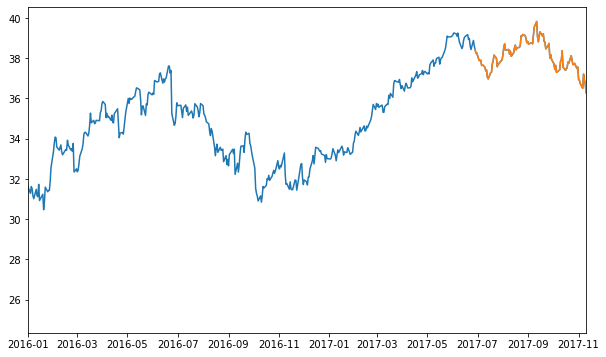

In [22]:
fig = plt.figure(figsize=(10,6))

plt.plot(df_sales_pred['Date'], df_sales_pred['Close'], label='actual')
plt.plot(df_sales_pred['Date'], df_sales_pred['pred_value'], label='predicted')
plt.xlim([datetime.date(2016, 1, 1), df_sales_pred['Date'].max()])